In [21]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
# !pip install gluonts=="0.4.1"

In [24]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [25]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


In [26]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [27]:
dataname = "m4_weekly"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


In [28]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length
print("length train dataset:", len(dataset.train))
print("length test dataset:", len(dataset.test))

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset: 359
length test dataset: 359


In [29]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

## Plot Series

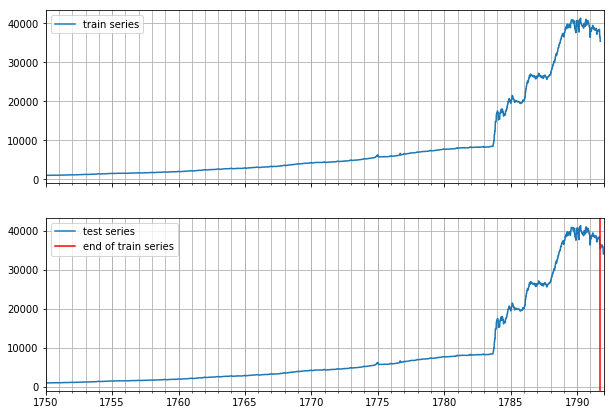

In [30]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [31]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-04 00:00:00
target: [1089.2  1078.91 1079.88 1063.58 1060.61 1056.93 1056.63]
feat_static_cat: [0]
length: 359


In [32]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

In [33]:
#########################
### deepstate wrapper ###

# data = "m4_yearly_other"
# seed = 44
# epochs = 500
# num_batches = 100
# batch_size = 32

def deepstate(dataname, seed=42, epochs=100, num_batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(dataname, regenerate=False)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches
    output["data"] = dataname

    df = pd.DataFrame([output])
    return df

## Results

In [34]:
results = pd.DataFrame()

for i in range(57, 62):
    print("Seed:", i)
    df=deepstate(dataname="m4_yearly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 57


INFO:root:Number of parameters in DeepStateTrainingNetwork: 1179349
100%|██████████| 100/100 [00:01<00:00, 52.40it/s, avg_epoch_loss=0.202]
INFO:root:Epoch[0] Elapsed time 1.910 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.202059
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.63it/s, avg_epoch_loss=-.396]
INFO:root:Epoch[1] Elapsed time 1.835 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.395838
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.24it/s, avg_epoch_loss=-.519]
INFO:root:Epoch[2] Elapsed time 1.845 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.518621
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.51it/s, avg_epoch_loss=-.557]
INFO:root:Epoch[3] Elapsed time 1.837 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.557498
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.70it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[37] Elapsed time 1.900 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.152722
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-2.09]
INFO:root:Epoch[38] Elapsed time 1.843 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.094148
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[39] Elapsed time 1.848 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.977570
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.59it/s, avg_epoch_loss=-1.76]
INFO:root:Epoch[40] Elapsed time 1.869 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.761811
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.71it/s, avg_epoch_loss=-2.41]
INFO:root:Epoch[74] Elapsed time 1.936 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.407021
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-2.31]
INFO:root:Epoch[75] Elapsed time 1.839 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.309314
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.35it/s, avg_epoch_loss=-2.1]
INFO:root:Epoch[76] Elapsed time 1.951 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.098492
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.77it/s, avg_epoch_loss=-2.36]
INFO:root:Epoch[77] Elapsed time 1.861 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.358540
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.72it/s, avg_epoch_loss=-

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.611582
INFO:root:Epoch[111] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.76it/s, avg_epoch_loss=-2.6]
INFO:root:Epoch[111] Elapsed time 1.829 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.599976
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-2.4]
INFO:root:Epoch[112] Elapsed time 1.849 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.399027
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=-2.46]
INFO:root:Epoch[113] Elapsed time 1.869 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-2.460216
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 52.37it/s, avg_epoch_loss=-2.22]
INFO:root:Epoch[114] Elapsed time 1.914 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch

100%|██████████| 100/100 [00:01<00:00, 54.51it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[146] Elapsed time 1.836 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.951041
INFO:root:Epoch[147] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.38it/s, avg_epoch_loss=-3.12]
INFO:root:Epoch[147] Elapsed time 1.913 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-3.119722
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[148] Elapsed time 1.858 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.859213
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.46it/s, avg_epoch_loss=-3]
INFO:root:Epoch[149] Elapsed time 1.946 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=-3.000805
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.01it/s, avg_epoch_loss=-2.62]
INFO:root:Epoch[150

100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[181] Elapsed time 1.842 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.309113
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.58it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[182] Elapsed time 1.835 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.791890
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.61it/s, avg_epoch_loss=-2.82]
INFO:root:Epoch[183] Elapsed time 1.868 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.819057
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-2.6]
INFO:root:Epoch[184] Elapsed time 1.879 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.598352
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.44it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[185] Elap

100%|██████████| 100/100 [00:01<00:00, 52.80it/s, avg_epoch_loss=-3.48]
INFO:root:Epoch[217] Elapsed time 1.895 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.482012
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3]
INFO:root:Epoch[218] Elapsed time 1.844 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.998457
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.81it/s, avg_epoch_loss=-2.99]
INFO:root:Epoch[219] Elapsed time 1.932 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-2.991732
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.26it/s, avg_epoch_loss=-2.83]
INFO:root:Epoch[220] Elapsed time 1.915 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.832877
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.72it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[221] Elapse

100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-3.58]
INFO:root:Epoch[253] Elapsed time 1.845 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.578960
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[254] Elapsed time 1.898 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-3.172919
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.41it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[255] Elapsed time 1.807 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-3.079181
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.30it/s, avg_epoch_loss=-3]
INFO:root:Epoch[256] Elapsed time 1.810 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.998306
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.39it/s, avg_epoch_loss=-3.12]
INFO:root:Epoch[257] Elapse

100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[289] Elapsed time 1.852 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.613282
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=-3.24]
INFO:root:Epoch[290] Elapsed time 1.879 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-3.235066
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[291] Elapsed time 1.845 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-3.171229
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-3.12]
INFO:root:Epoch[292] Elapsed time 1.847 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-3.115319
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=-3.65]
INFO:root:Epoch[325] Elapsed time 1.841 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.650722
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.75it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[326] Elapsed time 1.828 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.259420
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.67it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[327] Elapsed time 1.831 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-3.207741
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.72it/s, avg_epoch_loss=-3.2]
INFO:root:Epoch[328] Elapsed time 1.829 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-3.203915
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.87it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[329] Elap

100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[361] Elapsed time 1.847 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.686962
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[362] Elapsed time 1.847 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.309964
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.52it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[363] Elapsed time 1.836 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-3.247418
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[364] Elapsed time 1.846 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-3.305834
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.10it/s, avg_epoch_loss=-3.37]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 53.97it/s, avg_epoch_loss=-3.75]
INFO:root:Epoch[397] Elapsed time 1.855 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.746448
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[398] Elapsed time 1.845 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.337350
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.50it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[399] Elapsed time 1.837 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-3.294708
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.55it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[400] Elapsed time 1.943 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-3.378149
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.45it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:01<00:00, 54.13it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[433] Elapsed time 1.850 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.774679
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.42]
INFO:root:Epoch[434] Elapsed time 1.847 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.419665
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[435] Elapsed time 1.843 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-3.305851
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.18it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[436] Elapsed time 1.848 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.446909
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.61it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:01<00:00, 53.62it/s, avg_epoch_loss=-3.84]
INFO:root:Epoch[469] Elapsed time 1.867 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.835394
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.48]
INFO:root:Epoch[470] Elapsed time 1.842 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.484867
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.39it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[471] Elapsed time 1.840 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-3.349120
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.05it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[472] Elapsed time 1.854 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.548544
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.06it/s, avg_epoch_loss=-3.4]
INFO:root:Epoch[473] Elap

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.637877  0.153339  127.518528            0.151301            0.188976   

   seed  epochs  num_batches       data  
0    57     500          100  m4_yearly  
Seed: 58


100%|██████████| 100/100 [00:01<00:00, 52.70it/s, avg_epoch_loss=0.246]
INFO:root:Epoch[0] Elapsed time 1.901 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.246412
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.69it/s, avg_epoch_loss=-.358]
INFO:root:Epoch[1] Elapsed time 1.830 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.357984
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-.47]
INFO:root:Epoch[2] Elapsed time 1.850 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.470067
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.47it/s, avg_epoch_loss=-.535]
INFO:root:Epoch[3] Elapsed time 1.872 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.535482
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-.578]
INFO:root:Epoch[4] Elapsed time 1.857 seconds
INFO

100%|██████████| 100/100 [00:01<00:00, 55.25it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[37] Elapsed time 1.812 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.188828
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.82it/s, avg_epoch_loss=-2.16]
INFO:root:Epoch[38] Elapsed time 1.826 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.158436
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.98it/s, avg_epoch_loss=-2.02]
INFO:root:Epoch[39] Elapsed time 1.821 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.022294
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.08it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[40] Elapsed time 1.818 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.803751
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.37it/s, avg_epoc

100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[73] Elapsed time 1.852 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-2.669222
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.43it/s, avg_epoch_loss=-2.44]
INFO:root:Epoch[74] Elapsed time 1.839 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.436742
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.43it/s, avg_epoch_loss=-2.34]
INFO:root:Epoch[75] Elapsed time 1.806 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.342674
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.39it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[76] Elapsed time 1.840 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.031597
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-2.41]
INFO:root:Epoch[77] Elapsed 

100%|██████████| 100/100 [00:01<00:00, 54.44it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[109] Elapsed time 1.839 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-3.042808
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.27it/s, avg_epoch_loss=-2.64]
INFO:root:Epoch[110] Elapsed time 1.812 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.643659
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.12it/s, avg_epoch_loss=-2.71]
INFO:root:Epoch[111] Elapsed time 1.921 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.706720
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.04it/s, avg_epoch_loss=-2.45]
INFO:root:Epoch[112] Elapsed time 1.820 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.450167
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:0

100%|██████████| 100/100 [00:01<00:00, 55.48it/s, avg_epoch_loss=-2.61]
INFO:root:Epoch[144] Elapsed time 1.804 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-2.612699
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.65it/s, avg_epoch_loss=-3]
INFO:root:Epoch[145] Elapsed time 1.902 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-2.996443
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.81it/s, avg_epoch_loss=-2.46]
INFO:root:Epoch[146] Elapsed time 1.897 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.461190
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.15it/s, avg_epoch_loss=-2.59]
INFO:root:Epoch[147] Elapsed time 1.815 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-2.587803
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-2.33]
INFO:root:Epoch[148] Elapse

100%|██████████| 100/100 [00:01<00:00, 54.51it/s, avg_epoch_loss=-2.8]
INFO:root:Epoch[180] Elapsed time 1.837 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-2.804937
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.41it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[181] Elapsed time 1.911 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.264993
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-2.69]
INFO:root:Epoch[182] Elapsed time 1.851 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.693641
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.90it/s, avg_epoch_loss=-2.82]
INFO:root:Epoch[183] Elapsed time 1.895 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.822668
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.41it/s, avg_epoch_loss=-2.51]
INFO:root:Epoch[184] Elap

100%|██████████| 100/100 [00:01<00:00, 55.28it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[216] Elapsed time 1.812 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-2.954219
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.03it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[217] Elapsed time 1.819 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.349776
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.52it/s, avg_epoch_loss=-2.87]
INFO:root:Epoch[218] Elapsed time 1.870 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.869239
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[219] Elapsed time 1.878 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-2.917820
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-2.62]
INFO:root:Epoch[220] Ela

100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[252] Elapsed time 1.845 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-3.045292
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.26it/s, avg_epoch_loss=-3.4]
INFO:root:Epoch[253] Elapsed time 1.879 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.399056
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[254] Elapsed time 1.839 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.973620
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.88it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[255] Elapsed time 1.894 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-2.958567
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.94it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[256] Elap

100%|██████████| 100/100 [00:01<00:00, 54.24it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[288] Elapsed time 1.847 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-3.084644
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.01it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[289] Elapsed time 1.854 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.444290
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.57it/s, avg_epoch_loss=-3.01]
INFO:root:Epoch[290] Elapsed time 1.868 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-3.013185
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.83it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[291] Elapsed time 1.861 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-2.952794
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:01<00:00, 53.73it/s, avg_epoch_loss=-3.16]
INFO:root:Epoch[324] Elapsed time 1.863 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-3.157933
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.00it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[325] Elapsed time 1.856 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.493945
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.46it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[326] Elapsed time 1.805 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.059794
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.07it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[327] Elapsed time 1.817 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-2.973786
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.33it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:01<00:00, 53.41it/s, avg_epoch_loss=-3.23]
INFO:root:Epoch[360] Elapsed time 1.874 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-3.230400
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.65it/s, avg_epoch_loss=-3.5]
INFO:root:Epoch[361] Elapsed time 1.903 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.500501
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.97it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[362] Elapsed time 1.855 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.049134
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.43it/s, avg_epoch_loss=-3.01]
INFO:root:Epoch[363] Elapsed time 1.839 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-3.008947
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.47it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[364] Elap

100%|██████████| 100/100 [00:01<00:00, 53.25it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[396] Elapsed time 1.880 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-3.289408
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[397] Elapsed time 1.873 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.544555
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.52it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[398] Elapsed time 1.836 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.100430
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.41it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[399] Elapsed time 1.840 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-3.038924
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.23it/s, avg_epoch_loss=-3.2]
INFO:root:Epoch[400] Elaps

100%|██████████| 100/100 [00:01<00:00, 54.12it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[432] Elapsed time 1.850 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-3.347282
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.28it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[433] Elapsed time 1.844 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.533832
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-3.2]
INFO:root:Epoch[434] Elapsed time 1.845 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.203225
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.92it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[435] Elapsed time 1.856 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-3.075563
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[436] Elap

100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.46]
INFO:root:Epoch[468] Elapsed time 1.854 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-3.464198
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.98it/s, avg_epoch_loss=-3.58]
INFO:root:Epoch[469] Elapsed time 1.855 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.575575
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.96it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[470] Elapsed time 1.856 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.296676
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.16it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[471] Elapsed time 1.882 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-3.074355
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.01it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[472] Elap

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.652725  0.155011  130.660273            0.151464            0.199354   

   seed  epochs  num_batches       data  
0    58     500          100  m4_yearly  
Seed: 59


100%|██████████| 100/100 [00:01<00:00, 51.84it/s, avg_epoch_loss=0.26]
INFO:root:Epoch[0] Elapsed time 1.931 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.259766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.75it/s, avg_epoch_loss=-.395]
INFO:root:Epoch[1] Elapsed time 1.828 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.395102
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-.572]
INFO:root:Epoch[2] Elapsed time 1.844 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.572361
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.90it/s, avg_epoch_loss=-.586]
INFO:root:Epoch[3] Elapsed time 1.857 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.586412
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.08it/s, avg_epoch_loss=-.58]
INFO:root:Epoch[4] Elapsed time 1.922 seconds
INFO:

100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[37] Elapsed time 1.850 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.188934
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.47it/s, avg_epoch_loss=-2.14]
INFO:root:Epoch[38] Elapsed time 1.840 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.137487
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.03it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[39] Elapsed time 1.924 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.990574
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[40] Elapsed time 1.845 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.826973
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.88it/s, avg_epo

100%|██████████| 100/100 [00:01<00:00, 51.13it/s, avg_epoch_loss=-2.64]
INFO:root:Epoch[73] Elapsed time 1.958 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-2.641016
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-2.4]
INFO:root:Epoch[74] Elapsed time 1.844 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.404952
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.00it/s, avg_epoch_loss=-2.32]
INFO:root:Epoch[75] Elapsed time 1.853 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.317565
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=-2.02]
INFO:root:Epoch[76] Elapsed time 1.877 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.016392
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=-2.38]
INFO:root:Epoch[77] Elapsed t

INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.17it/s, avg_epoch_loss=-2.73]
INFO:root:Epoch[109] Elapsed time 1.847 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-2.732132
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-2.32]
INFO:root:Epoch[110] Elapsed time 1.841 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.323618
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=-2.39]
INFO:root:Epoch[111] Elapsed time 1.840 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.385781
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 53.77it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[112] Elapsed time 1.861 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.982152
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rat

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.24it/s, avg_epoch_loss=-2.87]
INFO:root:Epoch[145] Elapsed time 1.812 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-2.867310
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.13it/s, avg_epoch_loss=-2.33]
INFO:root:Epoch[146] Elapsed time 1.920 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.334268
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.92it/s, avg_epoch_loss=-2.53]
INFO:root:Epoch[147] Elapsed time 1.930 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-2.531616
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.95it/s, avg_epoch_loss=-2.09]
INFO:root:Epoch[148] Elapsed time 1.890 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.092405
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.04it/s, av

100%|██████████| 100/100 [00:01<00:00, 52.79it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[181] Elapsed time 1.897 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.095102
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-2.5]
INFO:root:Epoch[182] Elapsed time 1.862 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.501286
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-2.69]
INFO:root:Epoch[183] Elapsed time 1.852 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.691982
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.61it/s, avg_epoch_loss=-2.25]
INFO:root:Epoch[184] Elapsed time 1.870 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.251686
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.29it/s, avg_epoch_loss=-2.54]
INFO:root:Epoch[185] Elaps

100%|██████████| 100/100 [00:01<00:00, 52.35it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[217] Elapsed time 1.914 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.268128
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[218] Elapsed time 1.892 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.673041
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.05it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[219] Elapsed time 1.818 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-2.782558
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.39it/s, avg_epoch_loss=-2.4]
INFO:root:Epoch[220] Elapsed time 1.809 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.400067
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.15it/s, avg_epoch_loss=-2.7]
INFO:root:Epoch[221] Elaps

100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-3.22]
INFO:root:Epoch[253] Elapsed time 1.871 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.218540
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=-2.82]
INFO:root:Epoch[254] Elapsed time 1.870 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.823310
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.39it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[255] Elapsed time 1.810 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-2.790538
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.53it/s, avg_epoch_loss=-2.43]
INFO:root:Epoch[256] Elapsed time 1.803 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.426134
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.50it/s, avg_epoch_loss=-2.81]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:01<00:00, 53.55it/s, avg_epoch_loss=-3.24]
INFO:root:Epoch[289] Elapsed time 1.870 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.235550
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.32it/s, avg_epoch_loss=-2.9]
INFO:root:Epoch[290] Elapsed time 1.845 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-2.902497
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.62it/s, avg_epoch_loss=-2.77]
INFO:root:Epoch[291] Elapsed time 1.902 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-2.771405
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.12it/s, avg_epoch_loss=-2.55]
INFO:root:Epoch[292] Elapsed time 1.920 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-2.553627
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.95it/s, avg_epoch_loss=-2.84]
INFO:root:Epoch[293] Elap

100%|██████████| 100/100 [00:01<00:00, 52.30it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[325] Elapsed time 1.914 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.246563
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.23it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[326] Elapsed time 1.880 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-2.952075
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-2.8]
INFO:root:Epoch[327] Elapsed time 1.842 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-2.798255
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-2.71]
INFO:root:Epoch[328] Elapsed time 1.844 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-2.710705
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.52it/s, avg_epoch_loss=-2.93]
INFO:root:Epoch[329] Elap

100%|██████████| 100/100 [00:01<00:00, 51.41it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[361] Elapsed time 1.948 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.308495
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[362] Elapsed time 1.845 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-2.967808
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.23it/s, avg_epoch_loss=-2.83]
INFO:root:Epoch[363] Elapsed time 1.918 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-2.829120
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.58it/s, avg_epoch_loss=-2.83]
INFO:root:Epoch[364] Elapsed time 1.868 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-2.829737
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-2.98]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 55.29it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[397] Elapsed time 1.812 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.377643
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.25it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[398] Elapsed time 1.917 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.028422
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.88it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[399] Elapsed time 1.894 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-2.856395
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[400] Elapsed time 1.878 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-2.945134
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.21it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:01<00:00, 54.18it/s, avg_epoch_loss=-3.4]
INFO:root:Epoch[433] Elapsed time 1.847 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.403615
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[434] Elapsed time 1.851 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.099312
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[435] Elapsed time 1.851 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-2.863218
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[436] Elapsed time 1.843 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.045556
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.30it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[437] Elaps

100%|██████████| 100/100 [00:01<00:00, 54.52it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[469] Elapsed time 1.837 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.437388
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[470] Elapsed time 1.845 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.173442
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.14it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[471] Elapsed time 1.919 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-2.861236
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.73it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[472] Elapsed time 1.937 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.141833
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.22it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[473] Ela

       MASE    sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.074039  0.17739  146.044148            0.167916            0.237093   

   seed  epochs  num_batches       data  
0    59     500          100  m4_yearly  
Seed: 60


100%|██████████| 100/100 [00:01<00:00, 51.65it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[0] Elapsed time 1.938 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.189759
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.78it/s, avg_epoch_loss=-.388]
INFO:root:Epoch[1] Elapsed time 1.827 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.388195
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-.502]
INFO:root:Epoch[2] Elapsed time 1.871 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.501943
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.34it/s, avg_epoch_loss=-.521]
INFO:root:Epoch[3] Elapsed time 1.877 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.520908
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-.553]
INFO:root:Epoch[4] Elapsed time 1.878 seconds
INFO

100%|██████████| 100/100 [00:01<00:00, 54.95it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[37] Elapsed time 1.822 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.193676
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=-2.12]
INFO:root:Epoch[38] Elapsed time 1.859 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.122382
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.01it/s, avg_epoch_loss=-1.96]
INFO:root:Epoch[39] Elapsed time 1.925 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.959190
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.93it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[40] Elapsed time 1.967 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.804664
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.70it/s, avg_epoch_loss=-2.05]
INFO:root:Epoch[41] Elapsed time 1.97

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=-2.51]
INFO:root:Epoch[74] Elapsed time 1.852 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.513817
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.78it/s, avg_epoch_loss=-2.41]
INFO:root:Epoch[75] Elapsed time 1.862 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.410688
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.81it/s, avg_epoch_loss=-2.25]
INFO:root:Epoch[76] Elapsed time 1.863 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.247322
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.81it/s, avg_epoch_loss=-2.47]
INFO:root:Epoch[77] Elapsed time 1.863 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.468214
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.48it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 51.21it/s, avg_epoch_loss=-2.8]
INFO:root:Epoch[110] Elapsed time 1.955 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.800829
INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-2.84]
INFO:root:Epoch[111] Elapsed time 1.848 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.838636
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 52.47it/s, avg_epoch_loss=-2.63]
INFO:root:Epoch[112] Elapsed time 1.907 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.633905
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.68it/s, avg_epoch_loss=-2.53]
INFO:root:Epoch[113] Elapsed time 1.864 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-2.529909
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 5

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-3.377965
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.01it/s, avg_epoch_loss=-2.9]
INFO:root:Epoch[146] Elapsed time 1.925 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.897598
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.86it/s, avg_epoch_loss=-3.09]
INFO:root:Epoch[147] Elapsed time 1.896 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-3.094776
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.24it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[148] Elapsed time 1.880 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.793657
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.50it/s, avg_epoch_loss=-2.93]
INFO:root:Epoch[149] Elapsed time 1.909 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=-2.933380
INFO:root:Epoch[150] Le

100%|██████████| 100/100 [00:01<00:00, 53.69it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[181] Elapsed time 1.864 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.381500
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.40it/s, avg_epoch_loss=-2.76]
INFO:root:Epoch[182] Elapsed time 1.874 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.758875
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.05it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[183] Elapsed time 1.854 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.966008
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=-2.59]
INFO:root:Epoch[184] Elapsed time 1.846 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.594975
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[217] Elapsed time 1.851 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.522812
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.27it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[218] Elapsed time 1.915 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.958269
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.14it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[219] Elapsed time 1.920 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-3.057611
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.12it/s, avg_epoch_loss=-2.81]
INFO:root:Epoch[220] Elapsed time 1.885 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.807323
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.88it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:01<00:00, 55.40it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[253] Elapsed time 1.807 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.570494
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.72it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[254] Elapsed time 1.935 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-3.079893
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.09]
INFO:root:Epoch[255] Elapsed time 1.841 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-3.088737
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[256] Elapsed time 1.865 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.950869
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3.02]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[289] Elapsed time 1.852 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.615822
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.17it/s, avg_epoch_loss=-3.19]
INFO:root:Epoch[290] Elapsed time 1.848 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-3.190537
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.84it/s, avg_epoch_loss=-3.11]
INFO:root:Epoch[291] Elapsed time 1.894 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-3.108369
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.01it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[292] Elapsed time 1.853 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-3.072554
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 54.96it/s, avg_epoch_loss=-3.65]
INFO:root:Epoch[325] Elapsed time 1.821 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.653654
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3.22]
INFO:root:Epoch[326] Elapsed time 1.843 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.222357
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.82it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[327] Elapsed time 1.826 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-3.152151
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.16it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[328] Elapsed time 1.816 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-3.170241
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-3.68]
INFO:root:Epoch[361] Elapsed time 1.851 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.683757
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.24]
INFO:root:Epoch[362] Elapsed time 1.845 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.237679
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[363] Elapsed time 1.845 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-3.211497
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[364] Elapsed time 1.876 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-3.265018
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-3.22]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 53.17it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[397] Elapsed time 1.882 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.730362
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.30it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[398] Elapsed time 1.843 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.272344
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.32it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[399] Elapsed time 1.843 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-3.264521
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[400] Elapsed time 1.847 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-3.337349
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.03it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:01<00:00, 52.64it/s, avg_epoch_loss=-3.75]
INFO:root:Epoch[433] Elapsed time 1.901 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.745337
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.17it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[434] Elapsed time 1.847 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.347691
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[435] Elapsed time 1.857 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-3.299132
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.36it/s, avg_epoch_loss=-3.43]
INFO:root:Epoch[436] Elapsed time 1.989 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.429219
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[437] Elap

100%|██████████| 100/100 [00:01<00:00, 54.16it/s, avg_epoch_loss=-3.8]
INFO:root:Epoch[469] Elapsed time 1.848 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.799250
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.41it/s, avg_epoch_loss=-3.42]
INFO:root:Epoch[470] Elapsed time 1.840 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.415607
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.88it/s, avg_epoch_loss=-3.28]
INFO:root:Epoch[471] Elapsed time 1.858 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-3.275282
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.5]
INFO:root:Epoch[472] Elapsed time 1.844 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.501991
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.29it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[473] Elaps

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.554606  0.151979  125.540441             0.14997             0.18485   

   seed  epochs  num_batches       data  
0    60     500          100  m4_yearly  
Seed: 61


100%|██████████| 100/100 [00:01<00:00, 52.79it/s, avg_epoch_loss=0.213]
INFO:root:Epoch[0] Elapsed time 1.897 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.213218
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.62it/s, avg_epoch_loss=-.352]
INFO:root:Epoch[1] Elapsed time 1.902 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.352028
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.66it/s, avg_epoch_loss=-.397]
INFO:root:Epoch[2] Elapsed time 1.866 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.397378
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.41it/s, avg_epoch_loss=-.428]
INFO:root:Epoch[3] Elapsed time 1.840 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.428382
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.98it/s, avg_epoch_loss=-.502]
INFO:root:Epoch[4] Elapsed time 1.855 seconds
INF

100%|██████████| 100/100 [00:01<00:00, 53.13it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[37] Elapsed time 1.884 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.151387
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.75it/s, avg_epoch_loss=-2.11]
INFO:root:Epoch[38] Elapsed time 1.828 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.110665
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.29it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[39] Elapsed time 1.810 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.979732
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[40] Elapsed time 1.841 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.795061
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.13it/s, avg_epoc

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-2.578037
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-2.39]
INFO:root:Epoch[74] Elapsed time 1.850 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.392495
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-2.3]
INFO:root:Epoch[75] Elapsed time 1.846 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.296229
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=-2.08]
INFO:root:Epoch[76] Elapsed time 1.851 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.076668
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.87it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[77] Elapsed time 1.858 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.

100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-2.62]
INFO:root:Epoch[109] Elapsed time 1.845 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-2.622427
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.50it/s, avg_epoch_loss=-2.24]
INFO:root:Epoch[110] Elapsed time 1.837 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.242709
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.47it/s, avg_epoch_loss=-2.34]
INFO:root:Epoch[111] Elapsed time 1.838 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.335245
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.29it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[112] Elapsed time 1.845 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.989632
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:0

100%|██████████| 100/100 [00:01<00:00, 53.41it/s, avg_epoch_loss=-2.75]
INFO:root:Epoch[145] Elapsed time 1.876 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-2.749331
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=-2.24]
INFO:root:Epoch[146] Elapsed time 1.806 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.244099
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.48it/s, avg_epoch_loss=-2.45]
INFO:root:Epoch[147] Elapsed time 1.838 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-2.454655
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.23it/s, avg_epoch_loss=-2.08]
INFO:root:Epoch[148] Elapsed time 1.813 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.083380
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=-2.31]
INFO:root:Epoch[149] Ela

100%|██████████| 100/100 [00:01<00:00, 54.12it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[181] Elapsed time 1.849 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-2.915548
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.13it/s, avg_epoch_loss=-2.37]
INFO:root:Epoch[182] Elapsed time 1.920 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.369917
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.88it/s, avg_epoch_loss=-2.56]
INFO:root:Epoch[183] Elapsed time 1.859 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.558647
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.32it/s, avg_epoch_loss=-2.23]
INFO:root:Epoch[184] Elapsed time 1.845 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.230355
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-2.41]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:01<00:00, 50.54it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[217] Elapsed time 1.980 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.081194
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.58it/s, avg_epoch_loss=-2.54]
INFO:root:Epoch[218] Elapsed time 1.868 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.535403
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.83it/s, avg_epoch_loss=-2.63]
INFO:root:Epoch[219] Elapsed time 1.895 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-2.633884
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.32it/s, avg_epoch_loss=-2.42]
INFO:root:Epoch[220] Elapsed time 1.913 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.417683
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.78it/s, avg_epoch_loss=-2.54]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:01<00:00, 55.33it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[253] Elapsed time 1.809 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.181938
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.97it/s, avg_epoch_loss=-2.73]
INFO:root:Epoch[254] Elapsed time 1.855 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.733947
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=-2.7]
INFO:root:Epoch[255] Elapsed time 1.851 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-2.697320
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-2.55]
INFO:root:Epoch[256] Elapsed time 1.864 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.553001
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=-2.74]
INFO:root:Epoch[257] Elap

100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.22]
INFO:root:Epoch[289] Elapsed time 1.844 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.222181
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=-2.89]
INFO:root:Epoch[290] Elapsed time 1.849 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-2.887521
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=-2.73]
INFO:root:Epoch[291] Elapsed time 1.851 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-2.727092
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[292] Elapsed time 1.880 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-2.665984
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.18it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 55.17it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[325] Elapsed time 1.816 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.208317
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.93it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[326] Elapsed time 1.857 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-2.964282
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.26it/s, avg_epoch_loss=-2.74]
INFO:root:Epoch[327] Elapsed time 1.813 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-2.736985
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.04it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[328] Elapsed time 1.819 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-2.787759
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.13it/s, avg_epoch_loss=-2.9]
INFO:root:Epoch[329] Elap

100%|██████████| 100/100 [00:01<00:00, 51.91it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[361] Elapsed time 1.928 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.293894
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.68it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[362] Elapsed time 1.939 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-2.952779
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.67it/s, avg_epoch_loss=-2.82]
INFO:root:Epoch[363] Elapsed time 1.902 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-2.815771
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.86it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[364] Elapsed time 1.970 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-2.859791
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.67it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 53.97it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[397] Elapsed time 1.857 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.348263
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.28it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[398] Elapsed time 1.847 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.038071
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.12it/s, avg_epoch_loss=-2.85]
INFO:root:Epoch[399] Elapsed time 1.852 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-2.854815
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.79it/s, avg_epoch_loss=-2.93]
INFO:root:Epoch[400] Elapsed time 1.863 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-2.932634
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.04it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:01<00:00, 54.35it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[433] Elapsed time 1.842 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.346045
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.08]
INFO:root:Epoch[434] Elapsed time 1.853 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.081261
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.98it/s, avg_epoch_loss=-2.89]
INFO:root:Epoch[435] Elapsed time 1.855 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-2.893006
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[436] Elapsed time 1.862 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.046482
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[469] Elapsed time 1.840 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.411475
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[470] Elapsed time 1.851 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.073181
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.29it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[471] Elapsed time 1.846 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-2.913153
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.83it/s, avg_epoch_loss=-3.16]
INFO:root:Epoch[472] Elapsed time 1.860 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.164226
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-2.93]
INFO:root:Epoch[473] Ela

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.798202  0.164541  136.939986            0.160497            0.202828   

   seed  epochs  num_batches       data  
0    61     500          100  m4_yearly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,3.637877,0.153339,127.518528,0.151301,0.188976,57,500,100,m4_yearly
0,3.652725,0.155011,130.660273,0.151464,0.199354,58,500,100,m4_yearly
0,4.074039,0.177390,146.044148,0.167916,0.237093,59,500,100,m4_yearly
0,3.554606,0.151979,125.540441,0.149970,0.184850,60,500,100,m4_yearly
0,3.798202,0.164541,136.939986,0.160497,0.202828,61,500,100,m4_yearly


In [35]:
results = pd.DataFrame()

for i in range(52, 55):
    print("Seed:", i)
    df=deepstate(dataname="m4_yearly", seed=i, epochs=1000, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepStateTrainingNetwork: 1179349


Seed: 52


100%|██████████| 100/100 [00:01<00:00, 51.88it/s, avg_epoch_loss=0.214]
INFO:root:Epoch[0] Elapsed time 1.931 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.214436
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.49it/s, avg_epoch_loss=-.391]
INFO:root:Epoch[1] Elapsed time 1.837 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.391193
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.34it/s, avg_epoch_loss=-.483]
INFO:root:Epoch[2] Elapsed time 1.842 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.482990
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.95it/s, avg_epoch_loss=-.493]
INFO:root:Epoch[3] Elapsed time 1.856 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.492896
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.44it/s, avg_epoch_loss=-.548]
INFO:root:Epoch[4] Elapsed time 1.873 seconds
INF

100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=-2.17]
INFO:root:Epoch[37] Elapsed time 1.860 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.166379
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.49it/s, avg_epoch_loss=-2.13]
INFO:root:Epoch[38] Elapsed time 1.945 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.133886
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.13it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[39] Elapsed time 1.851 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.976575
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.82it/s, avg_epoch_loss=-1.79]
INFO:root:Epoch[40] Elapsed time 1.972 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.793854
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 52.48it/s, avg_epo

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-2.672566
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.39it/s, avg_epoch_loss=-2.53]
INFO:root:Epoch[74] Elapsed time 1.840 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.528216
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-2.39]
INFO:root:Epoch[75] Elapsed time 1.877 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.392358
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.58it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[76] Elapsed time 1.943 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.186278
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-2.23]
INFO:root:Epoch[77] Elapsed time 1.857 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2

100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=-2.98]
INFO:root:Epoch[109] Elapsed time 1.870 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-2.978744
INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-2.56]
INFO:root:Epoch[110] Elapsed time 1.846 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.560472
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.34it/s, avg_epoch_loss=-2.63]
INFO:root:Epoch[111] Elapsed time 1.876 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.629473
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.75it/s, avg_epoch_loss=-2.29]
INFO:root:Epoch[112] Elapsed time 1.974 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.293977
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.70it/s, avg_epoch_loss=-2.59]
INFO:root:Ep

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.28it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[145] Elapsed time 1.845 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-3.025371
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.91it/s, avg_epoch_loss=-2.47]
INFO:root:Epoch[146] Elapsed time 1.928 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.468594
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=-2.65]
INFO:root:Epoch[147] Elapsed time 1.855 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-2.651417
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.06it/s, avg_epoch_loss=-2.25]
INFO:root:Epoch[148] Elapsed time 1.818 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.253812
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.32it/s, av

100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[181] Elapsed time 1.852 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.208187
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.83it/s, avg_epoch_loss=-2.62]
INFO:root:Epoch[182] Elapsed time 1.861 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.623355
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[183] Elapsed time 1.843 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.791450
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.93it/s, avg_epoch_loss=-2.42]
INFO:root:Epoch[184] Elapsed time 1.891 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.418665
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-2.57]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:01<00:00, 53.62it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[217] Elapsed time 1.868 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.328480
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[218] Elapsed time 1.847 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.784195
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.92it/s, avg_epoch_loss=-2.83]
INFO:root:Epoch[219] Elapsed time 1.856 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-2.830308
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.91it/s, avg_epoch_loss=-2.58]
INFO:root:Epoch[220] Elapsed time 1.856 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.579136
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.21it/s, avg_epoch_loss=-2.72]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:01<00:00, 54.02it/s, avg_epoch_loss=-3.36]
INFO:root:Epoch[253] Elapsed time 1.853 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.357515
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.37it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[254] Elapsed time 1.808 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.921894
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.48it/s, avg_epoch_loss=-2.85]
INFO:root:Epoch[255] Elapsed time 1.837 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-2.847973
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.90it/s, avg_epoch_loss=-2.63]
INFO:root:Epoch[256] Elapsed time 1.825 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.630039
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.86it/s, avg_epoch_loss=-2.84]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[289] Elapsed time 1.852 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.376412
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[290] Elapsed time 1.850 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-2.960509
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.55it/s, avg_epoch_loss=-2.87]
INFO:root:Epoch[291] Elapsed time 1.869 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-2.873158
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=-2.68]
INFO:root:Epoch[292] Elapsed time 1.900 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-2.682499
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.65it/s, avg_epoch_loss=-2.89]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 53.83it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[325] Elapsed time 1.860 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.375232
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.84it/s, avg_epoch_loss=-3.01]
INFO:root:Epoch[326] Elapsed time 1.860 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.010813
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.37it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[327] Elapsed time 1.876 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-2.910958
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.59it/s, avg_epoch_loss=-2.86]
INFO:root:Epoch[328] Elapsed time 1.869 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-2.855503
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.28it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:01<00:00, 54.89it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[361] Elapsed time 1.825 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.407049
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.17it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[362] Elapsed time 1.814 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.026187
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.79it/s, avg_epoch_loss=-2.94]
INFO:root:Epoch[363] Elapsed time 1.827 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-2.943493
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.41it/s, avg_epoch_loss=-2.94]
INFO:root:Epoch[364] Elapsed time 1.840 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-2.935154
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.98it/s, avg_epoch_loss=-3.01]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[397] Elapsed time 1.843 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.454771
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.28it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[398] Elapsed time 1.844 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.039411
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.56it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[399] Elapsed time 1.942 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-2.963174
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.14it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[400] Elapsed time 1.919 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-3.095517
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.13it/s, avg_epoch_loss=-3.02]
INFO:root:Epoch[401] Elap

100%|██████████| 100/100 [00:01<00:00, 54.06it/s, avg_epoch_loss=-3.5]
INFO:root:Epoch[433] Elapsed time 1.851 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.496779
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[434] Elapsed time 1.845 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.142002
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-2.99]
INFO:root:Epoch[435] Elapsed time 1.849 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-2.987920
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[436] Elapsed time 1.848 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.184721
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.41it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[437] Elap

100%|██████████| 100/100 [00:01<00:00, 53.57it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[469] Elapsed time 1.870 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.518844
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.81it/s, avg_epoch_loss=-3.2]
INFO:root:Epoch[470] Elapsed time 1.971 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.201882
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[471] Elapsed time 1.878 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-2.963545
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[472] Elapsed time 1.879 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.265806
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.38it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[473] Elap

100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[505] Elapsed time 1.841 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-3.572241
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[506] Elapsed time 1.842 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-3.179288
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[507] Elapsed time 1.845 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-3.032504
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[508] Elapsed time 1.849 seconds
INFO:root:Epoch[508] Evaluation metric 'epoch_loss'=-3.384284
INFO:root:Epoch[509] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[509] Ela

100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[541] Elapsed time 1.852 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-3.565754
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[542] Elapsed time 1.847 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-3.211634
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.52it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[543] Elapsed time 1.870 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-3.098511
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.43]
INFO:root:Epoch[544] Elapsed time 1.841 seconds
INFO:root:Epoch[544] Evaluation metric 'epoch_loss'=-3.430350
INFO:root:Epoch[545] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.94it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[545] Elaps

100%|██████████| 100/100 [00:01<00:00, 54.80it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[577] Elapsed time 1.827 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-3.597189
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.18it/s, avg_epoch_loss=-3.16]
INFO:root:Epoch[578] Elapsed time 1.814 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-3.160167
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.46it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[579] Elapsed time 1.908 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-3.183161
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.23it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[580] Elapsed time 1.880 seconds
INFO:root:Epoch[580] Evaluation metric 'epoch_loss'=-3.439555
INFO:root:Epoch[581] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.49it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[581] Elap

100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[613] Elapsed time 1.844 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-3.585851
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-3.28]
INFO:root:Epoch[614] Elapsed time 1.847 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-3.275157
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[615] Elapsed time 1.862 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-3.183614
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.72it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[616] Elapsed time 1.866 seconds
INFO:root:Epoch[616] Evaluation metric 'epoch_loss'=-3.521431
INFO:root:Epoch[617] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.99it/s, avg_epoch_loss=-3.2]
INFO:root:Epoch[617] Elap

100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[649] Elapsed time 1.860 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-3.616413
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.29it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[650] Elapsed time 1.844 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-3.268792
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.82it/s, avg_epoch_loss=-3.24]
INFO:root:Epoch[651] Elapsed time 1.860 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-3.237463
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.98it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[652] Elapsed time 1.856 seconds
INFO:root:Epoch[652] Evaluation metric 'epoch_loss'=-3.533609
INFO:root:Epoch[653] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[653] Ela

100%|██████████| 100/100 [00:01<00:00, 54.90it/s, avg_epoch_loss=-3.56]
INFO:root:Epoch[685] Elapsed time 1.824 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-3.563287
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[686] Elapsed time 1.899 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-3.332487
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.57it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[687] Elapsed time 1.835 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-3.287876
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.76it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[688] Elapsed time 1.897 seconds
INFO:root:Epoch[688] Evaluation metric 'epoch_loss'=-3.529392
INFO:root:Epoch[689] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.80it/s, avg_epoch_loss=-3.23]
INFO:root:Epoch[689] Ela

100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[721] Elapsed time 1.843 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-3.547870
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.35it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[722] Elapsed time 1.841 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-3.536172
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.36it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[723] Elapsed time 1.949 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-3.405320
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.83it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[724] Elapsed time 1.860 seconds
INFO:root:Epoch[724] Evaluation metric 'epoch_loss'=-3.522567
INFO:root:Epoch[725] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.77it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[725] Ela

100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[757] Elapsed time 1.846 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-3.526777
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[758] Elapsed time 1.849 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-3.626207
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[759] Elapsed time 1.900 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-3.447771
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[760] Elapsed time 1.843 seconds
INFO:root:Epoch[760] Evaluation metric 'epoch_loss'=-3.569095
INFO:root:Epoch[761] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.73it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[761] Ela

100%|██████████| 100/100 [00:01<00:00, 55.08it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[793] Elapsed time 1.817 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-3.568900
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.05it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[794] Elapsed time 1.819 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-3.610044
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.81it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[795] Elapsed time 1.826 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-3.488349
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.33it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[796] Elapsed time 1.809 seconds
INFO:root:Epoch[796] Evaluation metric 'epoch_loss'=-3.567708
INFO:root:Epoch[797] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.32it/s, avg_epoch_loss=-3.32]
INFO:root:Epoch[797] Ela

100%|██████████| 100/100 [00:01<00:00, 54.83it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[829] Elapsed time 1.826 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-3.628562
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.12it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[830] Elapsed time 1.817 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-3.613407
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.96it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[831] Elapsed time 1.821 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-3.535674
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.11it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[832] Elapsed time 1.818 seconds
INFO:root:Epoch[832] Evaluation metric 'epoch_loss'=-3.569909
INFO:root:Epoch[833] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.54it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[833] Ela

100%|██████████| 100/100 [00:01<00:00, 51.67it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[865] Elapsed time 1.937 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-3.663518
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.96it/s, avg_epoch_loss=-3.51]
INFO:root:Epoch[866] Elapsed time 1.855 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-3.508605
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.18it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[867] Elapsed time 1.919 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-3.588008
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.30it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[868] Elapsed time 1.880 seconds
INFO:root:Epoch[868] Evaluation metric 'epoch_loss'=-3.592156
INFO:root:Epoch[869] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[869] Ela

100%|██████████| 100/100 [00:01<00:00, 54.23it/s, avg_epoch_loss=-3.72]
INFO:root:Epoch[901] Elapsed time 1.846 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-3.716838
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.46it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[902] Elapsed time 1.908 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-3.444185
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[903] Elapsed time 1.854 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-3.633390
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.05it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[904] Elapsed time 1.852 seconds
INFO:root:Epoch[904] Evaluation metric 'epoch_loss'=-3.593096
INFO:root:Epoch[905] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.13it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[905] Ela

100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=-3.75]
INFO:root:Epoch[937] Elapsed time 1.858 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-3.752656
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.30it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[938] Elapsed time 1.843 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-3.515612
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=-3.72]
INFO:root:Epoch[939] Elapsed time 1.848 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-3.722758
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-3.67]
INFO:root:Epoch[940] Elapsed time 1.839 seconds
INFO:root:Epoch[940] Evaluation metric 'epoch_loss'=-3.665667
INFO:root:Epoch[941] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[941] Ela

100%|██████████| 100/100 [00:01<00:00, 54.18it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[973] Elapsed time 1.850 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-3.733625
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.00it/s, avg_epoch_loss=-3.42]
INFO:root:Epoch[974] Elapsed time 1.856 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-3.423402
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-3.74]
INFO:root:Epoch[975] Elapsed time 1.864 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-3.739875
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.92it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[976] Elapsed time 1.966 seconds
INFO:root:Epoch[976] Evaluation metric 'epoch_loss'=-3.591191
INFO:root:Epoch[977] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[977] Ela

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.876884  0.160245  145.470637            0.158252            0.222737   

   seed  epochs  num_batches       data  
0    52    1000          100  m4_yearly  
Seed: 53


100%|██████████| 100/100 [00:01<00:00, 51.98it/s, avg_epoch_loss=0.217]
INFO:root:Epoch[0] Elapsed time 1.926 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.217121
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=-.339]
INFO:root:Epoch[1] Elapsed time 1.854 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.338834
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.49it/s, avg_epoch_loss=-.373]
INFO:root:Epoch[2] Elapsed time 1.907 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.372659
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.72it/s, avg_epoch_loss=-.422]
INFO:root:Epoch[3] Elapsed time 1.899 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.421907
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.41it/s, avg_epoch_loss=-.547]
INFO:root:Epoch[4] Elapsed time 1.910 seconds
INF

100%|██████████| 100/100 [00:01<00:00, 52.29it/s, avg_epoch_loss=-2.17]
INFO:root:Epoch[37] Elapsed time 1.915 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.174511
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.04it/s, avg_epoch_loss=-2.11]
INFO:root:Epoch[38] Elapsed time 1.961 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.113773
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[39] Elapsed time 1.853 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.868903
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.59it/s, avg_epoch_loss=-1.77]
INFO:root:Epoch[40] Elapsed time 1.870 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.773954
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.02it/s, avg_epoch_loss=-2.01]
INFO:root:Epoch[41] Elapsed time 1.8

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.34it/s, avg_epoch_loss=-2.52]
INFO:root:Epoch[74] Elapsed time 1.988 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.524206
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=-2.27]
INFO:root:Epoch[75] Elapsed time 2.367 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.272028
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.09it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[76] Elapsed time 1.959 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.179752
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-2.45]
INFO:root:Epoch[77] Elapsed time 1.852 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.451629
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.95it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[110] Elapsed time 1.852 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.783844
INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 52.95it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[111] Elapsed time 1.890 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.780226
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=-2.6]
INFO:root:Epoch[112] Elapsed time 1.859 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.603712
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.30it/s, avg_epoch_loss=-2.81]
INFO:root:Epoch[113] Elapsed time 1.954 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-2.809932
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=-2.49]
INFO:root:Epoch[114] 

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-3.328607
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 51.68it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[146] Elapsed time 1.937 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.907647
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[147] Elapsed time 1.849 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-3.053572
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-2.84]
INFO:root:Epoch[148] Elapsed time 1.853 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.838833
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.38it/s, avg_epoch_loss=-3]
INFO:root:Epoch[149] Elapsed time 1.913 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=-2.998311
INFO:root:Epoch[150] Lear

100%|██████████| 100/100 [00:01<00:00, 51.50it/s, avg_epoch_loss=-3.39]
INFO:root:Epoch[181] Elapsed time 1.943 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.391998
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.73it/s, avg_epoch_loss=-2.78]
INFO:root:Epoch[182] Elapsed time 1.863 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.783520
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[183] Elapsed time 1.858 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.972437
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.99it/s, avg_epoch_loss=-2.75]
INFO:root:Epoch[184] Elapsed time 1.888 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.747274
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.71it/s, avg_epoch_loss=-2.89]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:01<00:00, 54.34it/s, avg_epoch_loss=-3.5]
INFO:root:Epoch[217] Elapsed time 1.842 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.504234
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.39it/s, avg_epoch_loss=-2.96]
INFO:root:Epoch[218] Elapsed time 1.874 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.957233
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.55it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[219] Elapsed time 1.869 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-3.035705
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[220] Elapsed time 1.859 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.916887
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.94it/s, avg_epoch_loss=-2.98]
INFO:root:Epoch[221] Elap

100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=-3.51]
INFO:root:Epoch[253] Elapsed time 1.847 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.505813
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.93it/s, avg_epoch_loss=-3.11]
INFO:root:Epoch[254] Elapsed time 1.823 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-3.114264
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.97it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[255] Elapsed time 1.821 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-3.073703
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.89it/s, avg_epoch_loss=-3.01]
INFO:root:Epoch[256] Elapsed time 1.824 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-3.014405
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:01<00:00, 53.10it/s, avg_epoch_loss=-3.51]
INFO:root:Epoch[289] Elapsed time 1.885 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.509601
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[290] Elapsed time 1.879 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-3.173872
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[291] Elapsed time 1.852 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-3.060204
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=-3.12]
INFO:root:Epoch[292] Elapsed time 1.859 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-3.120615
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.06it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[325] Elapsed time 1.860 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.493867
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.61it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[326] Elapsed time 1.868 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.211417
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.60it/s, avg_epoch_loss=-3.1]
INFO:root:Epoch[327] Elapsed time 1.870 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-3.103245
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[328] Elapsed time 1.854 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-3.181580
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.13it/s, avg_epoch_loss=-3.11]
INFO:root:Epoch[329] Elap

100%|██████████| 100/100 [00:01<00:00, 52.98it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[361] Elapsed time 1.891 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.519941
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.35it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[362] Elapsed time 2.480 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.250805
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.73it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[363] Elapsed time 1.863 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-3.136008
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.24it/s, avg_epoch_loss=-3.23]
INFO:root:Epoch[364] Elapsed time 1.880 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-3.226490
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.02it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:01<00:00, 51.39it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[397] Elapsed time 1.950 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.538248
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[398] Elapsed time 1.854 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.265933
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.98it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[399] Elapsed time 1.965 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-3.138630
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[400] Elapsed time 1.862 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-3.211644
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[433] Elapsed time 1.839 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.596272
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.44it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[434] Elapsed time 1.839 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.330586
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[435] Elapsed time 1.845 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-3.135114
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.22]
INFO:root:Epoch[436] Elapsed time 1.841 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.220255
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[437] Elap

100%|██████████| 100/100 [00:01<00:00, 53.21it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[469] Elapsed time 1.881 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.595715
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.47it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[470] Elapsed time 1.874 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.333986
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.69it/s, avg_epoch_loss=-3.13]
INFO:root:Epoch[471] Elapsed time 1.900 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-3.131670
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.07it/s, avg_epoch_loss=-3.32]
INFO:root:Epoch[472] Elapsed time 1.888 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.323228
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.58it/s, avg_epoch_loss=-3.18]
INFO:root:Epoch[473] Elap

100%|██████████| 100/100 [00:01<00:00, 52.78it/s, avg_epoch_loss=-3.65]
INFO:root:Epoch[505] Elapsed time 1.896 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-3.650758
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.63it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[506] Elapsed time 1.866 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-3.335326
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.05it/s, avg_epoch_loss=-3.16]
INFO:root:Epoch[507] Elapsed time 1.886 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-3.155014
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.22it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[508] Elapsed time 1.881 seconds
INFO:root:Epoch[508] Evaluation metric 'epoch_loss'=-3.296339
INFO:root:Epoch[509] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.42it/s, avg_epoch_loss=-3.24]
INFO:root:Epoch[509] Elap

100%|██████████| 100/100 [00:01<00:00, 51.12it/s, avg_epoch_loss=-3.67]
INFO:root:Epoch[541] Elapsed time 1.960 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-3.666741
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.90it/s, avg_epoch_loss=-3.36]
INFO:root:Epoch[542] Elapsed time 2.046 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-3.355859
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.04it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[543] Elapsed time 1.888 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-3.212028
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.79it/s, avg_epoch_loss=-3.35]
INFO:root:Epoch[544] Elapsed time 1.861 seconds
INFO:root:Epoch[544] Evaluation metric 'epoch_loss'=-3.353238
INFO:root:Epoch[545] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.41it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[545] Ela

100%|██████████| 100/100 [00:01<00:00, 53.89it/s, avg_epoch_loss=-3.7]
INFO:root:Epoch[577] Elapsed time 1.858 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-3.700830
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.72it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[578] Elapsed time 1.863 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-3.343323
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.72it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[579] Elapsed time 2.014 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-3.272300
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.87it/s, avg_epoch_loss=-3.39]
INFO:root:Epoch[580] Elapsed time 1.930 seconds
INFO:root:Epoch[580] Evaluation metric 'epoch_loss'=-3.393053
INFO:root:Epoch[581] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.67it/s, avg_epoch_loss=-3.27]
INFO:root:Epoch[581] Elap

100%|██████████| 100/100 [00:01<00:00, 52.58it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[613] Elapsed time 1.905 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-3.693354
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.30it/s, avg_epoch_loss=-3.32]
INFO:root:Epoch[614] Elapsed time 1.951 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-3.317060
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.22it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[615] Elapsed time 1.956 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-3.245852
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.00it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[616] Elapsed time 1.888 seconds
INFO:root:Epoch[616] Evaluation metric 'epoch_loss'=-3.384488
INFO:root:Epoch[617] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[617] Ela

100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[649] Elapsed time 1.839 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-3.690954
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.37]
INFO:root:Epoch[650] Elapsed time 1.842 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-3.367106
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[651] Elapsed time 1.840 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-3.309991
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.01it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[652] Elapsed time 1.888 seconds
INFO:root:Epoch[652] Evaluation metric 'epoch_loss'=-3.411315
INFO:root:Epoch[653] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.38it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[653] Ela

100%|██████████| 100/100 [00:02<00:00, 49.43it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[685] Elapsed time 2.025 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-3.663436
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.43it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[686] Elapsed time 1.985 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-3.454821
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.82it/s, avg_epoch_loss=-3.36]
INFO:root:Epoch[687] Elapsed time 1.931 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-3.360995
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.25it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[688] Elapsed time 1.879 seconds
INFO:root:Epoch[688] Evaluation metric 'epoch_loss'=-3.450076
INFO:root:Epoch[689] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.08it/s, avg_epoch_loss=-3.4]
INFO:root:Epoch[689] Elap

100%|██████████| 100/100 [00:01<00:00, 50.94it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[721] Elapsed time 1.966 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-3.615598
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.65it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[722] Elapsed time 1.901 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-3.600525
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.10it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[723] Elapsed time 1.888 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-3.450199
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.96it/s, avg_epoch_loss=-3.51]
INFO:root:Epoch[724] Elapsed time 1.892 seconds
INFO:root:Epoch[724] Evaluation metric 'epoch_loss'=-3.514598
INFO:root:Epoch[725] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.16it/s, avg_epoch_loss=-3.38]
INFO:root:Epoch[725] Elap

100%|██████████| 100/100 [00:01<00:00, 53.97it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[757] Elapsed time 1.854 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-3.567795
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.56it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[758] Elapsed time 1.869 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-3.631656
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.93it/s, avg_epoch_loss=-3.48]
INFO:root:Epoch[759] Elapsed time 1.857 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-3.483197
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.84it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[760] Elapsed time 1.859 seconds
INFO:root:Epoch[760] Evaluation metric 'epoch_loss'=-3.524039
INFO:root:Epoch[761] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.92it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[761] Ela

100%|██████████| 100/100 [00:01<00:00, 54.81it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[793] Elapsed time 1.826 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-3.565786
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.54it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[794] Elapsed time 1.836 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-3.664644
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.02it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[795] Elapsed time 1.888 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-3.523566
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.58it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[796] Elapsed time 1.834 seconds
INFO:root:Epoch[796] Evaluation metric 'epoch_loss'=-3.541354
INFO:root:Epoch[797] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.63it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[797] Ela

100%|██████████| 100/100 [00:01<00:00, 54.98it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[829] Elapsed time 1.823 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-3.604874
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.67it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[830] Elapsed time 1.831 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-3.612296
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.04it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[831] Elapsed time 1.854 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-3.567990
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.71it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[832] Elapsed time 1.831 seconds
INFO:root:Epoch[832] Evaluation metric 'epoch_loss'=-3.621931
INFO:root:Epoch[833] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.01it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[833] Elap

100%|██████████| 100/100 [00:01<00:00, 53.96it/s, avg_epoch_loss=-3.65]
INFO:root:Epoch[865] Elapsed time 1.855 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-3.652279
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.71it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[866] Elapsed time 1.864 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-3.590155
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.28it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[867] Elapsed time 1.954 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-3.627540
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.13it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[868] Elapsed time 1.884 seconds
INFO:root:Epoch[868] Evaluation metric 'epoch_loss'=-3.585908
INFO:root:Epoch[869] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.11it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[869] Ela

100%|██████████| 100/100 [00:01<00:00, 53.42it/s, avg_epoch_loss=-3.72]
INFO:root:Epoch[901] Elapsed time 1.874 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-3.717312
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.50it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[902] Elapsed time 1.871 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-3.615410
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[903] Elapsed time 1.852 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-3.694157
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.05it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[904] Elapsed time 1.887 seconds
INFO:root:Epoch[904] Evaluation metric 'epoch_loss'=-3.606828
INFO:root:Epoch[905] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.53it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[905] Ela

100%|██████████| 100/100 [00:01<00:00, 53.39it/s, avg_epoch_loss=-3.74]
INFO:root:Epoch[937] Elapsed time 1.875 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-3.735058
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.25it/s, avg_epoch_loss=-3.56]
INFO:root:Epoch[938] Elapsed time 1.879 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-3.564082
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.46it/s, avg_epoch_loss=-3.74]
INFO:root:Epoch[939] Elapsed time 1.872 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-3.744135
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.94it/s, avg_epoch_loss=-3.64]
INFO:root:Epoch[940] Elapsed time 1.890 seconds
INFO:root:Epoch[940] Evaluation metric 'epoch_loss'=-3.637300
INFO:root:Epoch[941] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.25it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[941] Ela

100%|██████████| 100/100 [00:01<00:00, 54.34it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[973] Elapsed time 1.842 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-3.694631
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.47it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[974] Elapsed time 1.872 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-3.518534
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.92it/s, avg_epoch_loss=-3.78]
INFO:root:Epoch[975] Elapsed time 1.856 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-3.775287
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[976] Elapsed time 1.843 seconds
INFO:root:Epoch[976] Evaluation metric 'epoch_loss'=-3.618275
INFO:root:Epoch[977] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.80it/s, avg_epoch_loss=-3.64]
INFO:root:Epoch[977] Ela

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.868821  0.160684  144.25173            0.158887             0.22076   

   seed  epochs  num_batches       data  
0    53    1000          100  m4_yearly  
Seed: 54


100%|██████████| 100/100 [00:01<00:00, 50.58it/s, avg_epoch_loss=0.215]
INFO:root:Epoch[0] Elapsed time 1.981 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.214786
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.34it/s, avg_epoch_loss=-.366]
INFO:root:Epoch[1] Elapsed time 1.842 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.366090
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.72it/s, avg_epoch_loss=-.47]
INFO:root:Epoch[2] Elapsed time 1.863 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.470066
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.71it/s, avg_epoch_loss=-.533]
INFO:root:Epoch[3] Elapsed time 1.863 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.533259
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.28it/s, avg_epoch_loss=-.569]
INFO:root:Epoch[4] Elapsed time 1.879 seconds
INFO

100%|██████████| 100/100 [00:01<00:00, 50.17it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[37] Elapsed time 1.995 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.181006
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.28it/s, avg_epoch_loss=-2.12]
INFO:root:Epoch[38] Elapsed time 1.879 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.122908
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.05it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[39] Elapsed time 1.852 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.954304
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.54it/s, avg_epoch_loss=-1.81]
INFO:root:Epoch[40] Elapsed time 1.870 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.808440
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.61it/s, avg_epoch_loss=-2.08]
INFO:root:Epoch[41] Elapsed time 1.9

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.69it/s, avg_epoch_loss=-2.48]
INFO:root:Epoch[74] Elapsed time 1.901 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.479235
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.07it/s, avg_epoch_loss=-2.39]
INFO:root:Epoch[75] Elapsed time 1.922 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.392056
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.94it/s, avg_epoch_loss=-2.24]
INFO:root:Epoch[76] Elapsed time 1.929 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.241045
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.91it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[77] Elapsed time 1.856 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.178948
INFO:root:Epoch[78] Learning rate is 0.0005
100%|████████

INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.86it/s, avg_epoch_loss=-2.84]
INFO:root:Epoch[110] Elapsed time 1.894 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.837042
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.69it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[111] Elapsed time 1.901 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.912481
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.27it/s, avg_epoch_loss=-2.63]
INFO:root:Epoch[112] Elapsed time 1.916 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.626392
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 53.69it/s, avg_epoch_loss=-2.81]
INFO:root:Epoch[113] Elapsed time 1.864 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-2.806560
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.

100%|██████████| 100/100 [00:01<00:00, 52.26it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[145] Elapsed time 1.917 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-3.048677
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.16it/s, avg_epoch_loss=-2.57]
INFO:root:Epoch[146] Elapsed time 1.885 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-2.567232
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.76it/s, avg_epoch_loss=-2.76]
INFO:root:Epoch[147] Elapsed time 1.899 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-2.758578
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.60it/s, avg_epoch_loss=-2.37]
INFO:root:Epoch[148] Elapsed time 1.868 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-2.366712
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.12it/s, avg_epoch_loss=-2.57]
INFO:root:Epoch[149] Ela

100%|██████████| 100/100 [00:01<00:00, 52.90it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[181] Elapsed time 1.894 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-3.262074
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.19it/s, avg_epoch_loss=-2.77]
INFO:root:Epoch[182] Elapsed time 1.882 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.765513
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.17it/s, avg_epoch_loss=-2.95]
INFO:root:Epoch[183] Elapsed time 1.885 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-2.945436
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=-2.59]
INFO:root:Epoch[184] Elapsed time 1.879 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-2.590759
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.01it/s, avg_epoch_loss=-2.75]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:01<00:00, 53.88it/s, avg_epoch_loss=-3.44]
INFO:root:Epoch[217] Elapsed time 1.859 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-3.440864
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.65it/s, avg_epoch_loss=-2.94]
INFO:root:Epoch[218] Elapsed time 1.866 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-2.938059
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.69it/s, avg_epoch_loss=-3.04]
INFO:root:Epoch[219] Elapsed time 1.902 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-3.039703
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.09it/s, avg_epoch_loss=-2.79]
INFO:root:Epoch[220] Elapsed time 1.887 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-2.794395
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:01<00:00, 53.21it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[253] Elapsed time 1.881 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-3.523055
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.21it/s, avg_epoch_loss=-3.14]
INFO:root:Epoch[254] Elapsed time 1.881 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-3.135059
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.95it/s, avg_epoch_loss=-3.11]
INFO:root:Epoch[255] Elapsed time 1.964 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-3.111667
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.42it/s, avg_epoch_loss=-2.97]
INFO:root:Epoch[256] Elapsed time 1.874 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-2.973092
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.34it/s, avg_epoch_loss=-3.09]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:01<00:00, 53.96it/s, avg_epoch_loss=-3.57]
INFO:root:Epoch[289] Elapsed time 1.855 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-3.568905
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[290] Elapsed time 1.898 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-3.252988
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.31it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[291] Elapsed time 1.992 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-3.146780
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=-3.16]
INFO:root:Epoch[292] Elapsed time 1.891 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-3.156044
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.82it/s, avg_epoch_loss=-3.15]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:01<00:00, 51.55it/s, avg_epoch_loss=-3.58]
INFO:root:Epoch[325] Elapsed time 1.944 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-3.578454
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.20it/s, avg_epoch_loss=-3.31]
INFO:root:Epoch[326] Elapsed time 1.920 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-3.305278
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.38it/s, avg_epoch_loss=-3.17]
INFO:root:Epoch[327] Elapsed time 1.912 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-3.171459
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.01it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[328] Elapsed time 1.889 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-3.259177
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=-3.25]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:01<00:00, 52.94it/s, avg_epoch_loss=-3.61]
INFO:root:Epoch[361] Elapsed time 1.891 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-3.612312
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=-3.33]
INFO:root:Epoch[362] Elapsed time 1.879 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-3.328655
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.62it/s, avg_epoch_loss=-3.21]
INFO:root:Epoch[363] Elapsed time 1.904 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-3.214526
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.08it/s, avg_epoch_loss=-3.36]
INFO:root:Epoch[364] Elapsed time 1.886 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-3.355638
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.38it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[365] Elap

100%|██████████| 100/100 [00:01<00:00, 50.17it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[397] Elapsed time 1.997 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-3.661714
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.04it/s, avg_epoch_loss=-3.37]
INFO:root:Epoch[398] Elapsed time 1.887 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-3.372943
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.00it/s, avg_epoch_loss=-3.23]
INFO:root:Epoch[399] Elapsed time 1.888 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-3.233238
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.00it/s, avg_epoch_loss=-3.4]
INFO:root:Epoch[400] Elapsed time 1.888 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-3.404517
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.44it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[401] Elaps

100%|██████████| 100/100 [00:01<00:00, 51.73it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[433] Elapsed time 1.935 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-3.690456
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.43it/s, avg_epoch_loss=-3.46]
INFO:root:Epoch[434] Elapsed time 1.909 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-3.462580
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[435] Elapsed time 1.895 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-3.255824
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-3.49]
INFO:root:Epoch[436] Elapsed time 1.876 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-3.486204
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.21it/s, avg_epoch_loss=-3.29]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:01<00:00, 50.91it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[469] Elapsed time 1.966 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-3.692847
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.70it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[470] Elapsed time 1.937 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-3.525792
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.95it/s, avg_epoch_loss=-3.26]
INFO:root:Epoch[471] Elapsed time 1.892 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-3.259007
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[472] Elapsed time 1.881 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-3.552795
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.08it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[473] Elap

100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[505] Elapsed time 1.864 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-3.766303
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.67it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[506] Elapsed time 1.939 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-3.527598
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.45it/s, avg_epoch_loss=-3.3]
INFO:root:Epoch[507] Elapsed time 1.839 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-3.295341
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[508] Elapsed time 1.849 seconds
INFO:root:Epoch[508] Evaluation metric 'epoch_loss'=-3.626326
INFO:root:Epoch[509] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.22it/s, avg_epoch_loss=-3.32]
INFO:root:Epoch[509] Elap

100%|██████████| 100/100 [00:01<00:00, 53.79it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[541] Elapsed time 1.861 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-3.770057
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.37it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[542] Elapsed time 1.876 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-3.598657
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.47it/s, avg_epoch_loss=-3.37]
INFO:root:Epoch[543] Elapsed time 1.872 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-3.368210
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[544] Elapsed time 1.876 seconds
INFO:root:Epoch[544] Evaluation metric 'epoch_loss'=-3.689758
INFO:root:Epoch[545] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.57it/s, avg_epoch_loss=-3.34]
INFO:root:Epoch[545] Elap

100%|██████████| 100/100 [00:01<00:00, 52.95it/s, avg_epoch_loss=-3.8]
INFO:root:Epoch[577] Elapsed time 1.890 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-3.796028
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.88it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[578] Elapsed time 1.967 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-3.616541
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.80it/s, avg_epoch_loss=-3.43]
INFO:root:Epoch[579] Elapsed time 2.010 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-3.425928
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.47it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[580] Elapsed time 1.872 seconds
INFO:root:Epoch[580] Evaluation metric 'epoch_loss'=-3.656463
INFO:root:Epoch[581] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.58it/s, avg_epoch_loss=-3.39]
INFO:root:Epoch[581] Elap

100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=-3.8]
INFO:root:Epoch[613] Elapsed time 1.851 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-3.800338
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.96it/s, avg_epoch_loss=-3.65]
INFO:root:Epoch[614] Elapsed time 1.928 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-3.647497
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.06it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[615] Elapsed time 1.852 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-3.452219
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[616] Elapsed time 1.841 seconds
INFO:root:Epoch[616] Evaluation metric 'epoch_loss'=-3.725657
INFO:root:Epoch[617] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.08it/s, avg_epoch_loss=-3.45]
INFO:root:Epoch[617] Elap

100%|██████████| 100/100 [00:02<00:00, 46.09it/s, avg_epoch_loss=-3.82]
INFO:root:Epoch[649] Elapsed time 2.173 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-3.815823
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.29it/s, avg_epoch_loss=-3.64]
INFO:root:Epoch[650] Elapsed time 2.211 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-3.641748
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.60it/s, avg_epoch_loss=-3.46]
INFO:root:Epoch[651] Elapsed time 1.867 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-3.463605
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.52it/s, avg_epoch_loss=-3.7]
INFO:root:Epoch[652] Elapsed time 1.908 seconds
INFO:root:Epoch[652] Evaluation metric 'epoch_loss'=-3.699286
INFO:root:Epoch[653] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=-3.46]
INFO:root:Epoch[653] Elap

100%|██████████| 100/100 [00:02<00:00, 49.49it/s, avg_epoch_loss=-3.8]
INFO:root:Epoch[685] Elapsed time 2.023 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-3.800833
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.20it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[686] Elapsed time 2.764 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-3.725585
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.44it/s, avg_epoch_loss=-3.54]
INFO:root:Epoch[687] Elapsed time 2.746 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-3.537764
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.65it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[688] Elapsed time 1.938 seconds
INFO:root:Epoch[688] Evaluation metric 'epoch_loss'=-3.731558
INFO:root:Epoch[689] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.66it/s, avg_epoch_loss=-3.46]
INFO:root:Epoch[689] Elap

100%|██████████| 100/100 [00:01<00:00, 52.55it/s, avg_epoch_loss=-3.76]
INFO:root:Epoch[721] Elapsed time 1.905 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-3.758398
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.02it/s, avg_epoch_loss=-3.81]
INFO:root:Epoch[722] Elapsed time 1.889 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-3.806360
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.69it/s, avg_epoch_loss=-3.59]
INFO:root:Epoch[723] Elapsed time 1.901 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-3.585408
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.47it/s, avg_epoch_loss=-3.75]
INFO:root:Epoch[724] Elapsed time 1.985 seconds
INFO:root:Epoch[724] Evaluation metric 'epoch_loss'=-3.746597
INFO:root:Epoch[725] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.61it/s, avg_epoch_loss=-3.52]
INFO:root:Epoch[725] Ela

100%|██████████| 100/100 [00:01<00:00, 52.24it/s, avg_epoch_loss=-3.71]
INFO:root:Epoch[757] Elapsed time 1.917 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-3.708441
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.97it/s, avg_epoch_loss=-3.86]
INFO:root:Epoch[758] Elapsed time 1.890 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-3.863439
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.03it/s, avg_epoch_loss=-3.64]
INFO:root:Epoch[759] Elapsed time 1.888 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-3.638491
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.56it/s, avg_epoch_loss=-3.75]
INFO:root:Epoch[760] Elapsed time 1.905 seconds
INFO:root:Epoch[760] Evaluation metric 'epoch_loss'=-3.754757
INFO:root:Epoch[761] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.98it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[761] Ela

100%|██████████| 100/100 [00:01<00:00, 54.17it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[793] Elapsed time 1.848 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-3.770095
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=-3.84]
INFO:root:Epoch[794] Elapsed time 1.845 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-3.839043
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[795] Elapsed time 1.850 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-3.662376
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.33it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[796] Elapsed time 1.877 seconds
INFO:root:Epoch[796] Evaluation metric 'epoch_loss'=-3.767827
INFO:root:Epoch[797] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.43it/s, avg_epoch_loss=-3.6]
INFO:root:Epoch[797] Elap

100%|██████████| 100/100 [00:01<00:00, 53.05it/s, avg_epoch_loss=-3.82]
INFO:root:Epoch[829] Elapsed time 1.887 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-3.820972
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.76it/s, avg_epoch_loss=-3.77]
INFO:root:Epoch[830] Elapsed time 1.936 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-3.771498
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.52it/s, avg_epoch_loss=-3.72]
INFO:root:Epoch[831] Elapsed time 1.983 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-3.719034
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.27it/s, avg_epoch_loss=-3.81]
INFO:root:Epoch[832] Elapsed time 1.918 seconds
INFO:root:Epoch[832] Evaluation metric 'epoch_loss'=-3.813947
INFO:root:Epoch[833] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.83it/s, avg_epoch_loss=-3.62]
INFO:root:Epoch[833] Ela

100%|██████████| 100/100 [00:01<00:00, 52.63it/s, avg_epoch_loss=-3.88]
INFO:root:Epoch[865] Elapsed time 1.902 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-3.884907
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.57it/s, avg_epoch_loss=-3.72]
INFO:root:Epoch[866] Elapsed time 1.905 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-3.722567
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=-3.78]
INFO:root:Epoch[867] Elapsed time 1.879 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-3.783703
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.52it/s, avg_epoch_loss=-3.78]
INFO:root:Epoch[868] Elapsed time 1.870 seconds
INFO:root:Epoch[868] Evaluation metric 'epoch_loss'=-3.775344
INFO:root:Epoch[869] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.57it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[869] Ela

100%|██████████| 100/100 [00:01<00:00, 52.80it/s, avg_epoch_loss=-3.9]
INFO:root:Epoch[901] Elapsed time 1.897 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-3.896042
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.64it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[902] Elapsed time 2.019 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-3.689626
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.84it/s, avg_epoch_loss=-3.86]
INFO:root:Epoch[903] Elapsed time 1.895 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-3.862857
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=-3.82]
INFO:root:Epoch[904] Elapsed time 1.891 seconds
INFO:root:Epoch[904] Evaluation metric 'epoch_loss'=-3.815116
INFO:root:Epoch[905] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.12it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[905] Elap

100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.93]
INFO:root:Epoch[937] Elapsed time 1.843 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-3.932072
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=-3.7]
INFO:root:Epoch[938] Elapsed time 1.841 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-3.701694
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.33it/s, avg_epoch_loss=-3.95]
INFO:root:Epoch[939] Elapsed time 1.844 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-3.949777
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.36it/s, avg_epoch_loss=-3.84]
INFO:root:Epoch[940] Elapsed time 1.841 seconds
INFO:root:Epoch[940] Evaluation metric 'epoch_loss'=-3.840800
INFO:root:Epoch[941] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=-3.71]
INFO:root:Epoch[941] Elap

100%|██████████| 100/100 [00:03<00:00, 31.08it/s, avg_epoch_loss=-3.93]
INFO:root:Epoch[973] Elapsed time 3.225 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-3.927564
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.58it/s, avg_epoch_loss=-3.66]
INFO:root:Epoch[974] Elapsed time 3.174 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-3.661043
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.49it/s, avg_epoch_loss=-3.99]
INFO:root:Epoch[975] Elapsed time 3.183 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-3.988470
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.38it/s, avg_epoch_loss=-3.82]
INFO:root:Epoch[976] Elapsed time 3.298 seconds
INFO:root:Epoch[976] Evaluation metric 'epoch_loss'=-3.824149
INFO:root:Epoch[977] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.88it/s, avg_epoch_loss=-3.78]
INFO:root:Epoch[977] Ela

      MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.86565  0.162069  146.449282             0.15909            0.227049   

   seed  epochs  num_batches       data  
0    54    1000          100  m4_yearly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,3.876884,0.160245,145.470637,0.158252,0.222737,52,1000,100,m4_yearly
0,3.868821,0.160684,144.251730,0.158887,0.220760,53,1000,100,m4_yearly
0,3.865650,0.162069,146.449282,0.159090,0.227049,54,1000,100,m4_yearly


## m4_monthly

In [36]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:09<00:00,  5.16it/s, avg_epoch_loss=0.0975]
INFO:root:Epoch[0] Elapsed time 9.708 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.097503
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.34it/s, avg_epoch_loss=-.184]
INFO:root:Epoch[1] Elapsed time 9.360 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.183824
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.40it/s, avg_epoch_loss=0.317]
INFO:root:Epoch[2] Elapsed time 9.257 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.317048
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.38it/s, avg_epoch_loss=0.146]
INFO:root:Epoch[3] Elapsed time 9.299 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.146055
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.404726
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.32it/s, avg_epoch_loss=-.755]
INFO:root:Epoch[37] Elapsed time 9.410 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.755307
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss=31.1]
INFO:root:Epoch[38] Elapsed time 9.348 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.082841
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.41it/s, avg_epoch_loss=28.3]
INFO:root:Epoch[39] Elapsed time 9.254 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=28.282993
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=11.4]
INFO:root:Epoch[40] Elapsed time 9.434 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=11.37223

100%|██████████| 50/50 [00:09<00:00,  5.29it/s, avg_epoch_loss=-.796]
INFO:root:Epoch[73] Elapsed time 9.454 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.795789
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.36it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[74] Elapsed time 9.335 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.202862
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.43it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[75] Elapsed time 9.212 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.089581
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=-.883]
INFO:root:Epoch[76] Elapsed time 9.462 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.882560
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.42it/s, avg_epoch_loss=-.979]
INFO:root:Epoch[77] Elapsed time 9.221 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.041645  0.144527  24.763482            0.128765            0.104546   

   seed  epochs  num_batches        data  
0    42     100           50  m4_monthly  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:10<00:00,  4.99it/s, avg_epoch_loss=-.0425]
INFO:root:Epoch[0] Elapsed time 10.034 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.042517
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.38it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[1] Elapsed time 9.300 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.162277
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.46it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[2] Elapsed time 9.166 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.323491
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[3] Elapsed time 9.413 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.137540
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.33it/s, avg_epoch_lo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.453010
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=-.854]
INFO:root:Epoch[37] Elapsed time 9.414 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.854322
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=31.8]
INFO:root:Epoch[38] Elapsed time 9.435 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.828124
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.33it/s, avg_epoch_loss=31.1]
INFO:root:Epoch[39] Elapsed time 9.389 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=31.103307
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.46it/s, avg_epoch_loss=26.5]
INFO:root:Epoch[40] Elapsed time 9.162 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=26.45079

100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=-.832]
INFO:root:Epoch[73] Elapsed time 9.415 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.831842
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=-1.33]
INFO:root:Epoch[74] Elapsed time 9.453 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.325648
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.29it/s, avg_epoch_loss=-1.17]
INFO:root:Epoch[75] Elapsed time 9.450 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.166513
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.25it/s, avg_epoch_loss=-.904]
INFO:root:Epoch[76] Elapsed time 9.535 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.904105
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.45it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[77] Elapsed time 9.191 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.053558  0.144884  24.914019            0.129076            0.105729   

   seed  epochs  num_batches        data  
0    43     100           50  m4_monthly  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:10<00:00,  4.98it/s, avg_epoch_loss=-.0365]
INFO:root:Epoch[0] Elapsed time 10.048 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.036504
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.41it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1] Elapsed time 9.241 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.173689
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.32it/s, avg_epoch_loss=0.311]
INFO:root:Epoch[2] Elapsed time 9.398 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.310606
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.34it/s, avg_epoch_loss=0.153]
INFO:root:Epoch[3] Elapsed time 9.362 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.153423
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_lo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.400659
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.39it/s, avg_epoch_loss=-.759]
INFO:root:Epoch[37] Elapsed time 9.278 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.759321
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.13it/s, avg_epoch_loss=31.4]
INFO:root:Epoch[38] Elapsed time 9.765 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.421956
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.25it/s, avg_epoch_loss=31.8]
INFO:root:Epoch[39] Elapsed time 9.528 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=31.786386
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss=40.5]
INFO:root:Epoch[40] Elapsed time 9.356 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=40.50517

100%|██████████| 50/50 [00:09<00:00,  5.36it/s, avg_epoch_loss=-.818]
INFO:root:Epoch[73] Elapsed time 9.327 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.817788
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.28it/s, avg_epoch_loss=-1.31]
INFO:root:Epoch[74] Elapsed time 9.469 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.312840
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.28it/s, avg_epoch_loss=-1.16]
INFO:root:Epoch[75] Elapsed time 9.495 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.159360
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.26it/s, avg_epoch_loss=-.897]
INFO:root:Epoch[76] Elapsed time 9.514 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.897346
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.24it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[77] Elapsed time 9.542 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.054752  0.144718  24.903969            0.128937            0.106114   

   seed  epochs  num_batches        data  
0    44     100           50  m4_monthly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,1.041645,0.144527,24.763482,0.128765,0.104546,42,100,50,m4_monthly
0,1.053558,0.144884,24.914019,0.129076,0.105729,43,100,50,m4_monthly
0,1.054752,0.144718,24.903969,0.128937,0.106114,44,100,50,m4_monthly


In [37]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:19<00:00,  5.05it/s, avg_epoch_loss=-.0432]
INFO:root:Epoch[0] Elapsed time 19.807 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.043161
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 19.232 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.231552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=0.217]
INFO:root:Epoch[2] Elapsed time 18.737 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.216832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 18.822 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.516071
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.38it/s,

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.23it/s, avg_epoch_loss=-.289]
INFO:root:Epoch[36] Elapsed time 19.113 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.288513
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, avg_epoch_loss=-.98]
INFO:root:Epoch[37] Elapsed time 18.707 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.979626
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-.893]
INFO:root:Epoch[38] Elapsed time 18.973 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.893015
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-.504]
INFO:root:Epoch[39] Elapsed time 19.051 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.504310
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.33it/

INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.24it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[72] Elapsed time 19.091 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.97it/s, avg_epoch_loss=0.0941]
INFO:root:Epoch[73] Elapsed time 20.135 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.094116
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.43it/s, avg_epoch_loss=0.765]
INFO:root:Epoch[74] Elapsed time 18.422 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.765137
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.41it/s, avg_epoch_loss=-.482]
INFO:root:Epoch[75] Elapsed time 18.498 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.482122
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_los

100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=-.887]
INFO:root:Epoch[108] Elapsed time 18.758 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.887334
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[109] Elapsed time 19.067 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.159044
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=0.147]
INFO:root:Epoch[110] Elapsed time 18.375 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.147299
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.07it/s, avg_epoch_loss=-.347]
INFO:root:Epoch[111] Elapsed time 19.712 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.347408
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[112] 

100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-1.59]
INFO:root:Epoch[144] Elapsed time 19.163 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-1.593496
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=-.0494]
INFO:root:Epoch[145] Elapsed time 18.520 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.049365
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.30it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 18.887 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680015
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[147] Elapsed time 18.812 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.108088
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.75]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:19<00:00,  5.24it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[180] Elapsed time 19.073 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-1.799393
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[181] Elapsed time 18.684 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.950989
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.373]
INFO:root:Epoch[182] Elapsed time 18.822 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.372716
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[183] Elapsed time 19.172 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.867336
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[184] E

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.162233  0.150528  19.84857            0.136189            0.093922    42   

   epochs  num_batches        data  
0     200          100  m4_monthly  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:20<00:00,  4.89it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[0] Elapsed time 20.441 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.102397
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.43it/s, avg_epoch_loss=0.231]
INFO:root:Epoch[1] Elapsed time 18.431 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.230515
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=0.224]
INFO:root:Epoch[2] Elapsed time 18.520 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.224080
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-1.55]
INFO:root:Epoch[3] Elapsed time 19.157 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.550675
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.27]
INFO:root:Epoch[36] Elapsed time 18.802 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.269909
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[37] Elapsed time 19.236 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.124037
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:20<00:00,  4.98it/s, avg_epoch_loss=-.923]
INFO:root:Epoch[38] Elapsed time 20.104 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.923042
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.26it/s, avg_epoch_loss=-.425]
INFO:root:Epoch[39] Elapsed time 19.017 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.425172
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.34it/

100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[72] Elapsed time 18.949 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.150698
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.38it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[73] Elapsed time 18.585 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.117530
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.42it/s, avg_epoch_loss=0.792]
INFO:root:Epoch[74] Elapsed time 18.438 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.792282
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=-.495]
INFO:root:Epoch[75] Elapsed time 18.767 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.495404
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.92it/s, avg_epoch_loss=-.0877]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.912419
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[109] Elapsed time 19.053 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.173628
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.38it/s, avg_epoch_loss=0.159]
INFO:root:Epoch[110] Elapsed time 18.594 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.158547
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.42it/s, avg_epoch_loss=-.341] 
INFO:root:Epoch[111] Elapsed time 18.445 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.340997
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[112] Elapsed time 19.243 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.131463
INFO:root:Epoch[113] Learning 

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-.0412]
INFO:root:Epoch[145] Elapsed time 19.152 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.041248
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 18.919 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680289
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[147] Elapsed time 18.840 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.102259
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-.751]
INFO:root:Epoch[148] Elapsed time 18.924 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.751158
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s

100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[181] Elapsed time 18.928 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.951063
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.37it/s, avg_epoch_loss=-.383]
INFO:root:Epoch[182] Elapsed time 18.642 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.383097
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[183] Elapsed time 18.861 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.891928
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 18.718 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111665
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-.246]
INFO:root:Epoch[185]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.170947  0.151562  19.488244            0.137173            0.093113   

   seed  epochs  num_batches        data  
0    43     200          100  m4_monthly  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:19<00:00,  5.10it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[0] Elapsed time 19.610 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.105097
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.23it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 19.113 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.232014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.17it/s, avg_epoch_loss=0.246]
INFO:root:Epoch[2] Elapsed time 19.361 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.245871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 18.815 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.517245
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-.247]
INFO:root:Epoch[36] Elapsed time 18.991 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.247188
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[37] Elapsed time 18.987 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.076925
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-.909]
INFO:root:Epoch[38] Elapsed time 19.174 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.909007
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:20<00:00,  4.89it/s, avg_epoch_loss=-.453]
INFO:root:Epoch[39] Elapsed time 20.447 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.452669
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.36it

100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.15] 
INFO:root:Epoch[72] Elapsed time 18.806 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.149519
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[73] Elapsed time 18.970 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.113779
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.50it/s, avg_epoch_loss=0.783]
INFO:root:Epoch[74] Elapsed time 18.186 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.783257
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=-.491]
INFO:root:Epoch[75] Elapsed time 18.733 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.490949
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.15it/s, avg_epoch_loss=-.0923]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.961019
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-.2] 
INFO:root:Epoch[109] Elapsed time 18.848 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.200339
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=0.136]
INFO:root:Epoch[110] Elapsed time 18.940 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.135640
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.363]
INFO:root:Epoch[111] Elapsed time 18.926 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.362888
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.24it/s, avg_epoch_loss=-1.17]
INFO:root:Epoch[112] Elapsed time 19.102 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.167704
INFO:root:Epoch[113] Learning ra

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.30it/s, avg_epoch_loss=-.0633]
INFO:root:Epoch[145] Elapsed time 18.879 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.063269
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.37it/s, avg_epoch_loss=-1.67]
INFO:root:Epoch[146] Elapsed time 18.639 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.668130
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.36it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[147] Elapsed time 18.657 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.116230
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=-.765]
INFO:root:Epoch[148] Elapsed time 18.758 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.765273
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.36it/

100%|██████████| 100/100 [00:20<00:00,  4.88it/s, avg_epoch_loss=-.957]
INFO:root:Epoch[181] Elapsed time 20.498 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.956822
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.347]
INFO:root:Epoch[182] Elapsed time 18.784 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.346501
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[183] Elapsed time 19.052 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.883303
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 18.967 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111767
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-.224]
INFO:root:Epoch[185]

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.198005  0.152833  20.02421            0.138461            0.093832    44   

   epochs  num_batches        data  
0     200          100  m4_monthly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,1.162233,0.150528,19.848570,0.136189,0.093922,42,200,100,m4_monthly
0,1.170947,0.151562,19.488244,0.137173,0.093113,43,200,100,m4_monthly
0,1.198005,0.152833,20.024210,0.138461,0.093832,44,200,100,m4_monthly


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:19<00:00,  5.15it/s, avg_epoch_loss=-.0432]
INFO:root:Epoch[0] Elapsed time 19.444 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.043161
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 18.953 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.231552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.09it/s, avg_epoch_loss=0.217]
INFO:root:Epoch[2] Elapsed time 19.666 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.216832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 18.910 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.516071
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s,

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.19it/s, avg_epoch_loss=-.289]
INFO:root:Epoch[36] Elapsed time 19.265 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.288513
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.23it/s, avg_epoch_loss=-.98]
INFO:root:Epoch[37] Elapsed time 19.123 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.979626
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-.893]
INFO:root:Epoch[38] Elapsed time 18.842 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.893015
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-.504]
INFO:root:Epoch[39] Elapsed time 19.178 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.504310
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.13it/

INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[72] Elapsed time 10.841 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.24it/s, avg_epoch_loss=0.0941]
INFO:root:Epoch[73] Elapsed time 10.825 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.094116
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.30it/s, avg_epoch_loss=0.765]
INFO:root:Epoch[74] Elapsed time 10.755 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.765137
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-.482]
INFO:root:Epoch[75] Elapsed time 10.921 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.482122
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_los

100%|██████████| 100/100 [00:10<00:00,  9.17it/s, avg_epoch_loss=-.887]
INFO:root:Epoch[108] Elapsed time 10.910 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.887334
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.20it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[109] Elapsed time 10.869 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.159044
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.18it/s, avg_epoch_loss=0.147]
INFO:root:Epoch[110] Elapsed time 10.892 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.147299
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=-.347]
INFO:root:Epoch[111] Elapsed time 10.814 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.347408
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[112] 

100%|██████████| 100/100 [00:10<00:00,  9.22it/s, avg_epoch_loss=-1.59]
INFO:root:Epoch[144] Elapsed time 10.851 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-1.593496
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.30it/s, avg_epoch_loss=-.0494]
INFO:root:Epoch[145] Elapsed time 10.759 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.049365
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 10.837 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680015
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[147] Elapsed time 10.817 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.108088
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-.75]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:10<00:00,  9.11it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[180] Elapsed time 10.984 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-1.799393
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.12it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[181] Elapsed time 10.964 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.950989
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-.373]
INFO:root:Epoch[182] Elapsed time 10.773 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.372716
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.20it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[183] Elapsed time 10.867 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.867336
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.17it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[184] E

100%|██████████| 100/100 [00:10<00:00,  9.31it/s, avg_epoch_loss=-.982]
INFO:root:Epoch[216] Elapsed time 10.741 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.981972
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.19it/s, avg_epoch_loss=-2.07]
INFO:root:Epoch[217] Elapsed time 10.884 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-2.074324
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.31it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[218] Elapsed time 10.739 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-1.877232
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[219] Elapsed time 10.765 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-1.831458
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.43it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[220]

100%|██████████| 100/100 [00:10<00:00,  9.35it/s, avg_epoch_loss=-1.3]
INFO:root:Epoch[252] Elapsed time 10.697 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-1.298826
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=-.92]
INFO:root:Epoch[253] Elapsed time 10.717 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.920255
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=-.243]
INFO:root:Epoch[254] Elapsed time 11.183 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.243451
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[255] Elapsed time 10.777 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-1.874083
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[256] E

100%|██████████| 100/100 [00:10<00:00,  9.35it/s, avg_epoch_loss=-2.1]
INFO:root:Epoch[288] Elapsed time 10.700 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-2.104043
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.37it/s, avg_epoch_loss=-1.19]
INFO:root:Epoch[289] Elapsed time 10.678 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-1.185341
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.44it/s, avg_epoch_loss=-.283]
INFO:root:Epoch[290] Elapsed time 10.601 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.282846
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.39it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[291] Elapsed time 10.649 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-1.054788
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=-2.16]
INFO:root:Epoch[292] 

100%|██████████| 100/100 [00:10<00:00,  9.20it/s, avg_epoch_loss=-1.94]
INFO:root:Epoch[324] Elapsed time 10.877 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-1.941348
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.34it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[325] Elapsed time 10.714 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.150437
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.22it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[326] Elapsed time 10.851 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-1.994760
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-1.36]
INFO:root:Epoch[327] Elapsed time 10.784 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-1.359173
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-.961]
INFO:root:Epoch[328] 

100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[360] Elapsed time 10.917 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-1.986267
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[361] Elapsed time 10.926 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-1.103644
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-.692]
INFO:root:Epoch[362] Elapsed time 10.776 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.692318
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.19it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[363] Elapsed time 10.887 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-2.179178
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.21it/s, avg_epoch_loss=-1.29]
INFO:root:Epoch[364] 

100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=-1.18]
INFO:root:Epoch[396] Elapsed time 10.773 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-1.178460
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=-2.27]
INFO:root:Epoch[397] Elapsed time 10.935 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-2.271090
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=-2.06]
INFO:root:Epoch[398] Elapsed time 10.812 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-2.056243
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.30it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[399] Elapsed time 10.756 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-2.027368
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.40it/s, avg_epoch_loss=-.222]
INFO:root:Epoch[400]

100%|██████████| 100/100 [00:10<00:00,  9.36it/s, avg_epoch_loss=-1.53]
INFO:root:Epoch[432] Elapsed time 10.687 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-1.527478
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.39it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[433] Elapsed time 10.647 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-1.125481
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.45it/s, avg_epoch_loss=-.411]
INFO:root:Epoch[434] Elapsed time 10.583 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.410993
INFO:root:Epoch[435] Learning rate is 5e-05
  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=1000, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## m4 quarterly

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=1000, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results